## Import Packages

In [1]:
# data processing
import pandas as pd
import numpy as np
from pathlib import Path
from numpy import nanmean

# formatting
import re
def add_comma(match):
    return match.group(0) + ','

# statistical measures
from scipy.stats import pearsonr, mode 
from scipy import stats

# plots
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

# custom functions
from functions import getResponses, chooseData, chooseEmb, getEmbeddings, getData, predModel, corrUserBased # general auxiliary function
from functions import compareModels, modelPerformance # model training and comparison
from functions import regCorr, mean_confidence_interval, pearsonr_ci, welch_t_test # human judges comparison 1
from functions import targetComparison, predictionPerformance # human judges comparison 2

# random state
randState = 0

# warning messages
import warnings
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")

## Find Best Model (NEO-PI-R)

In [ ]:
compareModels(1) #runs through all possible models for each embeddings type
# choose verbose=1 to show the results of each model

MODEL: Ridge (par = 1) SENTENCEBERT:
Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF
[0.376, 0.369, 0.382, 0.0, 120.406, 2747]


MODEL: Ridge (par = 10) SENTENCEBERT:
Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF
[0.38, 0.374, 0.386, 0.0, 121.67, 2747]


MODEL: Ridge (par = 100) SENTENCEBERT:
Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF
[0.407, 0.401, 0.413, 0.0, 129.247, 2747]


MODEL: Ridge (par = 1000) SENTENCEBERT:
Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF
[0.445, 0.439, 0.451, 0.0, 143.953, 2747]


MODEL: Ridge (par = 10000) SENTENCEBERT:
Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF
[0.266, 0.259, 0.273, 0.0, 76.745, 2747]


MODEL: RidgeClass (par = 1) SENTENCEBERT:
Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF
[0.335, 0.329, 0.341, 0.0, 109.864, 2747]


MODEL: RidgeClass (par = 10) SENTENCEBERT:
Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF
[0.339, 0.333, 0.345, 0.0, 111.025, 2747]


MO

### Show all model performances (requires that previously was run at least once)

In [64]:
# create function to load all model results and save in dataframe
verbose = 0
d = "BIG5"                      #data sets:   # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
e = 'sentencebert'

#####################################################################################

# choose data set, embeddings, encoding
folder, data = chooseData(d)        # BIG5, IPIP (all items), RIASEC, HSQ, 16PF
embeddings, save = chooseEmb(e)     # LIWC, WORD2VEC, SENTENCEBERT
responses, savePath, items, _ = getResponses(folder, data, 2)
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings, responses)

# get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

rows = []
for k in range(5):                       # calculate for each prediction model: Ridge, 
      # model:
      m = k           #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
      # import required data and labels
      data_q, constructs_list, list_par, constrAssigned = getData(m, responses, X_pca_stand, folder, data)
      ##################################### load predictions #####################################

      for par in list_par: #iterate over parameters

        model, modelName = predModel(m, par, randState) 

        # load predictions
        total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col = 0) #save predictions -> to calculate and predict performance for plots

        # calculate performance
        results, resultsMean = corrUserBased(total_preds, responses)
        corr, pval, ci_lower, ci_upper, t, dof = resultsMean
        rows.append([modelName, par] + resultsMean)
        
        if verbose==1:
            # Model metrics:
            print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":") #hand over string with specs...
            print("Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF")
            print([round(corr,3), round(ci_lower,3), round(ci_upper,3), round(pval,3), round(t,3), round(dof,3)])
            print("\n")
        else:
            pass

df = pd.DataFrame(rows, columns = ["model", "parameter", "correlation", "ci-l", "ci-u", "p-value", "t-statistic", "dof"])

Show performance overview (choose model with highest performance)

In [17]:
df # KNN-Regression with K = 5

,model,parameter,correlation,ci-l,ci-u,p-value,t-statistic,dof
0,Ridge,1,0.375596,0.000000e+00,0.369480,0.381713,120.406289,2747
1,Ridge,10,0.379702,0.000000e+00,0.373582,0.385821,121.670351,2747
2,Ridge,100,0.407085,0.000000e+00,0.400909,0.413261,129.246551,2747
3,Ridge,1000,0.445420,0.000000e+00,0.439352,0.451487,143.953410,2747
4,Ridge,10000,0.266138,0.000000e+00,0.259338,0.272938,76.744713,2747
5,RidgeClass,1,0.335404,0.000000e+00,0.329418,0.341391,109.864133,2747
6,RidgeClass,10,0.339304,0.000000e+00,0.333311,0.345296,111.024752,2747
7,RidgeClass,100,0.365632,0.000000e+00,0.359562,0.371702,118.105836,2747
8,RidgeClass,1000,0.413384,0.000000e+00,0.407151,0.419616,130.058116,2747
9,RidgeClass,10000,0.347358,0.000000e+00,0.340328,0.354388,96.885073,2747


### Calculate performance of specified model

In [18]:
# specify best performing model: knnReg, K = 5, Sentencebert
modelPerformance(m=4, par=5, d="BIG5", e="sentencebert", verbose=1) #calculate and print performance
# m -> #0: Ridge regression, #1: RidgeClass, #2:KNN, #3: Kernel SVC (RBF), #4: KNN Regression

# Baseline -- Word2Vec: SVC C=10
modelPerformance(m=3, par=10, d="BIG5", e="word2vec", verbose=1)

# Baseline -- LIWC: Ridge a=10
modelPerformance(m=0, par=10, d="BIG5", e="liwc", verbose=1)

MODEL: KnnReg (par = 5) SENTENCEBERT:
Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF
[0.453, 0.447, 0.458, 0.0, 158.093, 2747]


MODEL: SVC (par = 10) WORD2VEC:
Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF
[0.128, 0.123, 0.133, 0.0, 51.683, 2747]


MODEL: Ridge (par = 10) LIWC:
Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF
[0.102, 0.097, 0.108, 0.0, 35.43, 2747]




1

## Show performance of best model

Loads results of previously fitted model

In [41]:
# for parameter m -> 0: Ridge regression, #1: RidgeClass, #2:KNN, #3: Kernel SVC (RBF), #4: KNN Regression

# specify best model for sbert:
# KNN with K=5:
sbert_specs = [4, 5] #model, parameter

# specify best model for word2vec:
# SVC with C=10:
word2vec_specs = [3, 10] #model, parameter

# specify best model for LIWC:
# Ridge with a=10:
liwc_specs = [0, 10] #model, parameter

model_specs = [sbert_specs, word2vec_specs, liwc_specs]
specs_dict = {0: "Ridge", 1: "RidgeClass", 2: "Knn", 3: "SVC", 4: "KnnReg"}

# get true item responses
d = "BIG5"
folder, data = chooseData(d)        
responses, savePath, items, _ = getResponses(folder, data, 2) #1: Reversed, #2: nonReversed

folder = "../results/"
models = ["LIWC", "WORD2VEC", "SENTENCEBERT"]
model_outputs = [specs_dict[model_specs[x][0]] + models[x] + "responses.csv" for x in range(len(models))]
model_outputs = ["Ridge_10_LIWC_responses.csv", "SVC_10_WORD2VEC_responses.csv", "KnnReg_5_SENTENCEBERT_responses.csv"]

for mo in model_outputs:
    path = folder + d.upper() + "/nonReversed/" + mo
    parameters = mo.split("_")
    print("Dataset: " + d.upper())
    print("Model: " + parameters[0].upper())
    print("Parameter: " + parameters[1].upper())
    print("Embedding Type: " + parameters[2].upper())
    
    # load results and calculate performance for each model
    x = pd.read_csv(path, index_col=0, dtype={'INDEX':str})
    x.index = x.index.map(str)
    y = responses.copy()
    results, resultsMean = corrUserBased(x, y)
    
    print("Correlation, p-value, lower-CI, upper-CI, t-statistic, DOF")
    print(list(np.round(resultsMean, 3))) #corr, p, ci lower, ci upper, t-stats, df
    print("\n")
    print("Percentage of significant positive correlations: ")
    print(round(np.mean((results.Correlation>0) & (results["p-value"]<0.05)), 3))
    print("\n")

Dataset: BIG5
Model: RIDGE
Parameter: 10
Embedding Type: LIWC
Correlation, p-value, lower-CI, upper-CI, t-statistic, DOF
[0.102, 0.0, 0.097, 0.108, 35.43, 2747.0]


Percentage of significant positive correlations: 
0.28


Dataset: BIG5
Model: SVC
Parameter: 10
Embedding Type: WORD2VEC
Correlation, p-value, lower-CI, upper-CI, t-statistic, DOF
[0.128, 0.0, 0.123, 0.133, 51.683, 2747.0]


Percentage of significant positive correlations: 
0.302


Dataset: BIG5
Model: KNNREG
Parameter: 5
Embedding Type: SENTENCEBERT
Correlation, p-value, lower-CI, upper-CI, t-statistic, DOF
[0.453, 0.0, 0.447, 0.458, 158.093, 2747.0]


Percentage of significant positive correlations: 
0.942




### Performance Plots (Model & Baselines)

#### Calculate and save performance (only run once)

In [43]:
# best performing model:
m   = 4               #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e   = 'sentencebert'

model, modelName = predModel(m,par) 

datasets = ['BIG5']
performance = pd.DataFrame(columns=["Dataset", "Model", "Correlation", "p-value", "L1 Loss"])
sig_data = []

# iterate through datasets
for i,nr in zip(datasets, range(len(datasets))):
  # add LIWC - Baseline
      # load prediction and baseline data
  folder, data = chooseData(i)
  responses, savePath, items, _ = getResponses(folder, data, 2)
  total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + e.upper() + "_responses.csv", index_col=0)
  total_dumb = pd.read_csv(savePath + 'baseline_responses.csv', index_col=0) #naive baseline
  responses.index = total_preds.index
       # get performances
  results, resultsMean = corrUserBased(total_preds, responses)
  results_dumb, resultsMean_dumb = corrUserBased(total_dumb, responses)
  results.insert(0,'Model',['Best Model']*results.shape[0])
  results.insert(0,'Dataset',[i]*results.shape[0])
  results_dumb.insert(0,'Model',['Average Response']*results_dumb.shape[0])
  results_dumb.insert(0,'Dataset',[i]*results_dumb.shape[0])
  
  # get percentage of significant positive correlations
  sig_count = results.loc[(results.Correlation > 0) & (results["p-value"]<0.05),:].shape[0]/results.shape[0]
  sig_data.append([i, "SBERT", sig_count])

  # combine correlations of all datasets in one frame
  performance = pd.concat([performance, results], ignore_index = True)

  # add word2vec Baseline
  mName_w2v = "SVC"
  par_w2v = 10
  total_preds3 = pd.read_csv(savePath + mName_w2v + "_" + str(par_w2v) + "_" + "WORD2VEC".upper() + "_responses.csv", index_col=0)
  responses.index = total_preds3.index
      #get performances
  results3, resultsMean2 = corrUserBased(total_preds3, responses)
  results3.insert(0,'Model',['WORD2VEC']*results3.shape[0])
  results3.insert(0,'Dataset',[i]*results3.shape[0])

  # get percentage of significant positive correlations
  sig_count = results3.loc[(results3.Correlation > 0) & (results3["p-value"]<0.05),:].shape[0]/results3.shape[0]
  sig_data.append([i, "WORD2VEC", sig_count])

  # combine correlations of all datasets in one frame
  performance = pd.concat([performance, results3], ignore_index = True)

  # add LIWC -- Baseline
  mName_liwc = "Ridge"
  par_liwc = 10
  total_preds2 = pd.read_csv(savePath + mName_liwc + "_" + str(par_liwc) + "_" + "LIWC".upper() + "_responses.csv", index_col=0)
  responses.index = total_preds2.index
      #get performances
  results2, resultsMean2 = corrUserBased(total_preds2, responses)
  results2.insert(0,'Model',['LIWC']*results.shape[0])
  results2.insert(0,'Dataset',[i]*results.shape[0])
  
  # get percentage of significant positive correlations
  sig_count = results2.loc[(results2.Correlation > 0) & (results2["p-value"]<0.05),:].shape[0]/results2.shape[0]
  sig_data.append([i, "LIWC", sig_count])

  # combine correlations of all datasets in one frame
  performance = pd.concat([performance, results2], ignore_index = True)
  performance = pd.concat([performance, results_dumb], ignore_index = True)

# save results
performance.to_csv("../plot_data/performances_s1.csv")

#### Plot from pre-saved data

<Figure size 3600x6480 with 0 Axes>

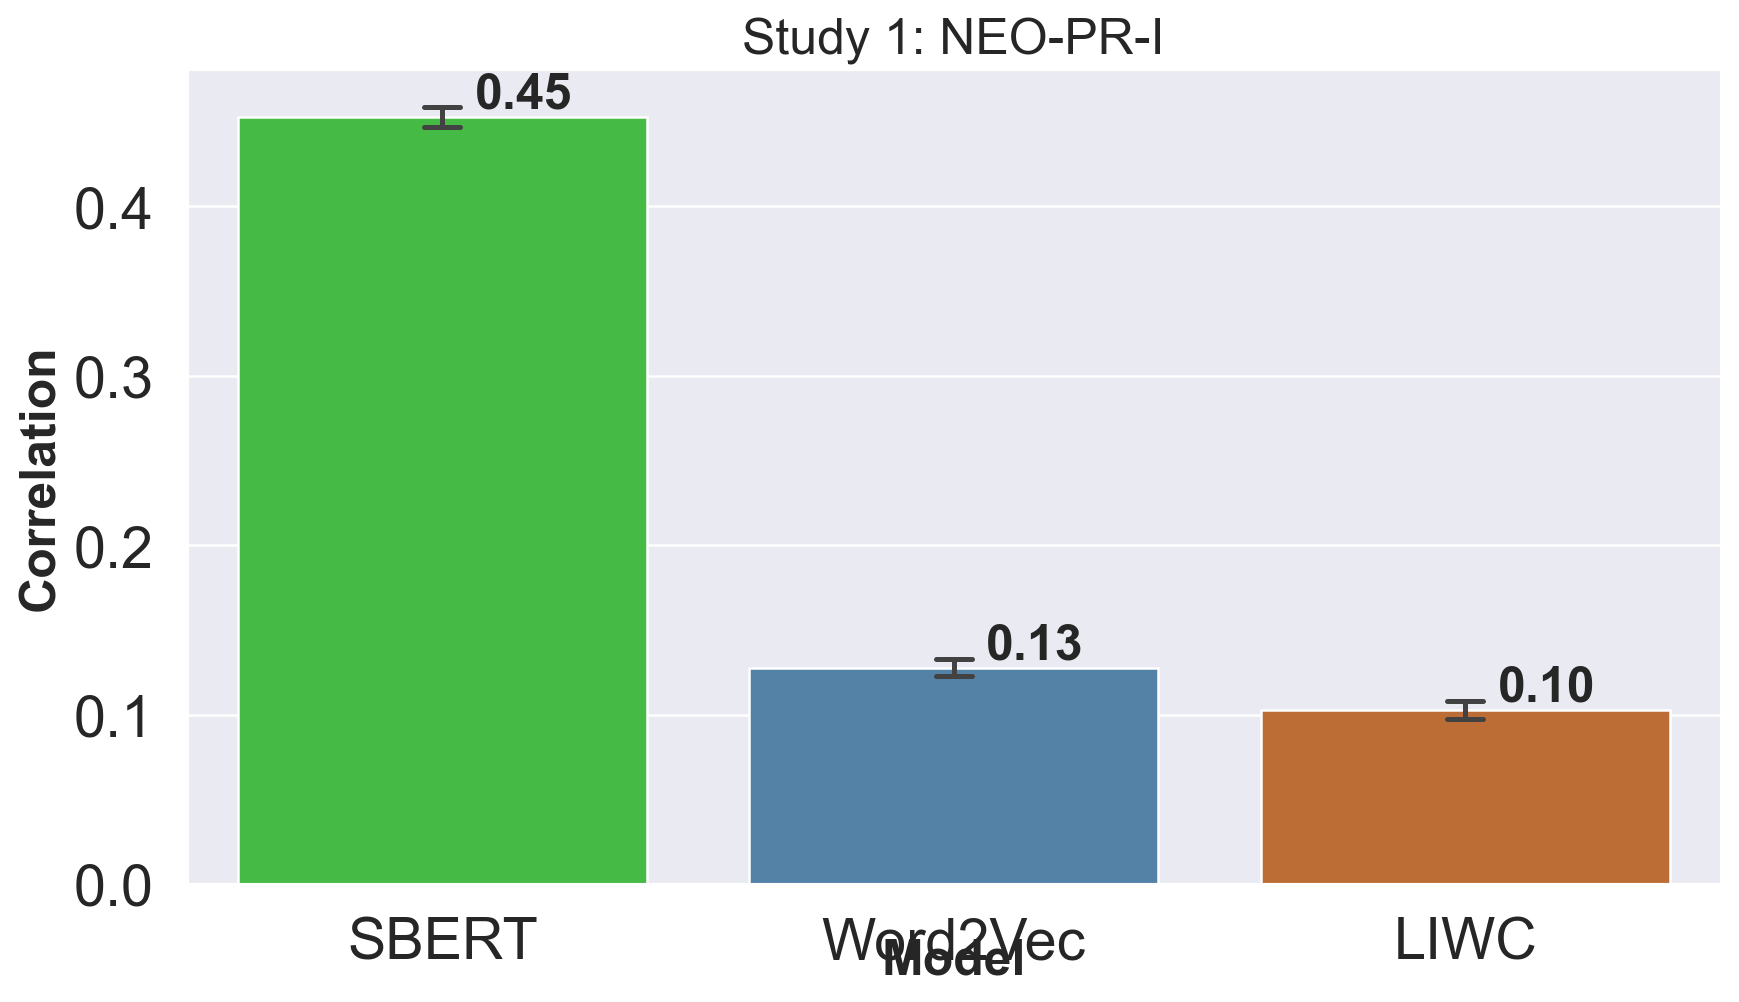

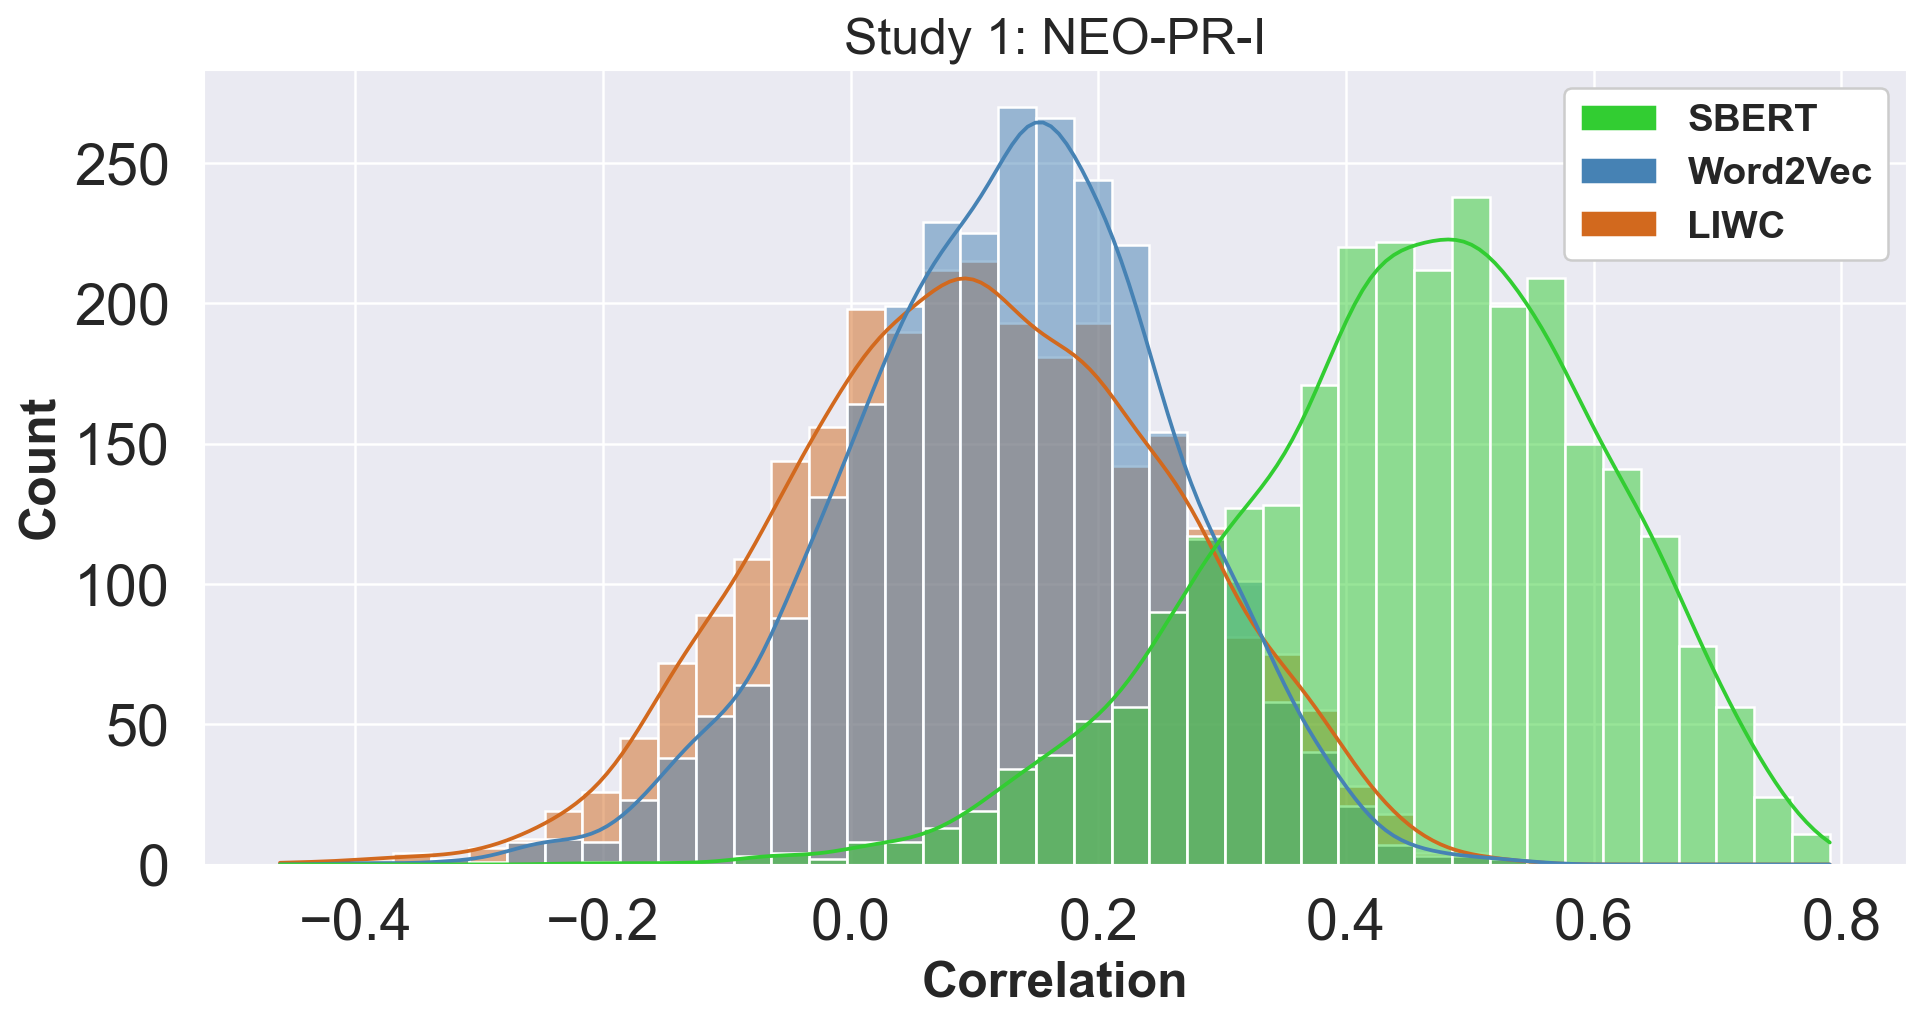

In [44]:
performance = pd.read_csv("../plot_data/performances_s1.csv", index_col=0)

# reshape data frame to show performance for each embedding type
cols = performance.columns.drop(['Dataset', 'Model'])
performance[cols] = performance[cols].astype(float)
performance = pd.melt(performance, id_vars=["Dataset", "Model"],var_name="predictor", value_name="metric value")
plot_data = performance[(performance['predictor'] == 'Correlation')].copy()
plot_data.loc[plot_data.Model == "Best Model", 'Model'] = "SBERT"

# rename for better display in plots
plot_data['Model'] = ["Word2Vec" if item=="WORD2VEC" else item for item in plot_data['Model']]
plot_data['Model'] = ["Average\nResponse" if item=="Average Response" else item for item in plot_data['Model']]

# create plots
fig  = plt.figure(figsize=(20, 36), dpi= 180)
sns.set(font_scale = 1)
order = ['BIG5']
dataset_names = ['Study 1: NEO-PR-I']

# Plot style and meta
plt.style.use("seaborn-v0_8")
sns.set_context('paper')
sns.set(font_scale = 1.4)
for i in range(1):

    # Add the performance plots:
    data = plot_data[(plot_data.Dataset == order[i]) & (plot_data.Model != "Average\nResponse")]
    fig  = plt.figure(figsize=(11, 6), dpi= 180)
    ax = sns.barplot(y='metric value', x='Model', orient='v', data=data, errorbar=('ci', 95), palette=["limegreen","steelblue", "chocolate", "sandybrown"], capsize=0.07, errwidth=2)
    for p in ax.patches:
      if p.get_height() < 0:
        height = -6
      else:
        height = 6
      ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x() + p.get_width() / 2, p.get_height()),
              xytext=(13, height + 3), textcoords='offset points', ha="left", va="center", fontweight='bold',fontsize=20)
    plt.ylabel("Correlation", fontweight='bold', fontsize=20)
    plt.xlabel("Model", fontweight='bold', fontsize=20, labelpad=-13)
    plt.title(dataset_names[i], fontsize=20)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)

    fig_name = "fig2_" + chr(65+2*i) + ".pdf"
    plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')

    # Add the distribution plots for each data set:
    fig  = plt.figure(figsize=(11, 6), dpi= 180)
    palette=["limegreen","steelblue", "chocolate"]
    ax = sns.histplot(data, x="metric value", kde=True, hue="Model", palette = palette)
    from matplotlib.patches import Patch
    handles = [Patch(facecolor=item) for item in palette]
    labels = data.Model.unique().tolist()
    ax.legend(handles = handles, labels = labels, frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})

    plt.ylabel("Count", fontweight='bold', fontsize=20)
    plt.xlabel("Correlation", fontweight='bold', fontsize=20)
    plt.title(dataset_names[i], fontsize=20)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)

    fig_name = "fig2_" + chr(65+2*i+1) + ".pdf"
    plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')

plt.tight_layout()
plt.subplots_adjust(hspace = 1)
plt.show()

## Human comparison

### Analysis I (depth - more raters per target)

Import experimental data (human judges and model predictions)

In [46]:
# import human judges data
xslx = pd.ExcelFile("../results/human_eval_unreversed.xlsx")
target_25 = pd.read_excel(xslx, "25%", index_col=0)
target_50 = pd.read_excel(xslx, "50%", index_col=0)
target_75 = pd.read_excel(xslx, "75%", index_col=0)
target_list = [(target_25, "25%"), (target_50, "50%"), (target_75, "75%")]

# model_performance = pd.read_csv("results/" + "best_model_results_userBased.csv", index_col=0)
predictions = pd.read_csv("../results/BIG5/nonReversed/" + "KnnReg_5_SENTENCEBERT_responses.csv", index_col=0)
predictions_targets = predictions.loc[[df[0].columns[1] for df in target_list],:]

Calculate performance and format for plotting

In [47]:
n_steps = 10
cor_h,p_h,cor_comp,p_comp = regCorr(target_list, n_steps, predictions_targets) #correlations
corrs_means = [np.nanmean(x).round(3) for x in cor_h] #humans
pvals_means = [np.nanmean(x).round(3) for x in p_h]
corrs_comps = [np.nanmean(x).round(3) for x in cor_comp] #computational model
pvals_comps = [np.nanmean(x).round(3) for x in p_comp]

# Confidence intervals
ci_corr_model = [mean_confidence_interval(x) for x in cor_comp] #comp model
yerr_model = [(x[2]-x[1])/2 for x in ci_corr_model]
ci_corr_human = [mean_confidence_interval(x) for x in cor_h] #humans
yerr_human = [(x[2]-x[1])/2 for x in ci_corr_human]

# create dataframe
# adjust to run over all percentiles
performance = pd.DataFrame(np.array([["25th percentile", 'Computational Model', corrs_comps[0], yerr_model[0]],
                                      ["50th percentile",'Computational Model', corrs_comps[1], yerr_model[1]],
                                      ["75th percentile", 'Computational Model', corrs_comps[2], yerr_model[2]],
                                          ["25th percentile", 'Human Raters', corrs_means[0], yerr_human[0]],
                                          ["50th percentile",'Human Raters',  corrs_means[1], yerr_human[1]],
                                          ["75th percentile", 'Human Raters',  corrs_means[2], yerr_human[2]]]), columns=["target", "model", "correlation", "yerr"])
performance.iloc[:, -2:] = performance.iloc[:, -2:].astype(float)
labels = performance.target.drop_duplicates().tolist() #bar labels
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

Show performance and compare humans vs model (target-level)

In [48]:
targets = ["25th percentile", "50th percentile", "75th percentile"]
for i in range(3):
    print("Target: " + str(targets[i]))
    # humans
    ttest_h = stats.ttest_1samp(cor_h[i], 0, nan_policy="omit") #test significance of performance against zero
    t_h = round(ttest_h[0], 3)
    p_h = round(ttest_h[1], 4)
    ci_human = [round(x, 3) for x in ci_corr_human[i]] #95% CI for predictive performance

    # model
    ttest_c = stats.ttest_1samp(cor_comp[i], 0, nan_policy="omit") #test significance of performance against zero
    t_c = round(ttest_c[0], 3)
    p_c = round(ttest_c[1], 4)
    ci_model = [round(x, 3) for x in ci_corr_model[i]] #95% CI for predictive performance

    # prints: performance estimate (correlation), t-statistic, p-value
    print("Human raters:")
    print("CI (mean, lower-CI, upper-CI), p-value, t-statistic, DOF")
    print(ci_human+[p_h, t_h, len(cor_h)-1])

    print("\nModel:")
    print("CI (mean, lower-CI, upper-CI), p-value, t-statistic, DOF")
    print(ci_model+[p_c, t_c, len(cor_comp)-1])
    
    print("\n")

Target: 25th percentile
Human raters:
CI (mean, lower-CI, upper-CI), p-value, t-statistic, DOF
[0.386, 0.343, 0.429, 0.0, 17.8, 2]

Model:
CI (mean, lower-CI, upper-CI), p-value, t-statistic, DOF
[0.379, 0.168, 0.59, 0.0028, 4.072, 2]


Target: 50th percentile
Human raters:
CI (mean, lower-CI, upper-CI), p-value, t-statistic, DOF
[0.58, 0.544, 0.616, 0.0, 31.537, 2]

Model:
CI (mean, lower-CI, upper-CI), p-value, t-statistic, DOF
[0.456, 0.244, 0.668, 0.0009, 4.856, 2]


Target: 75th percentile
Human raters:
CI (mean, lower-CI, upper-CI), p-value, t-statistic, DOF
[0.426, 0.378, 0.474, 0.0, 17.514, 2]

Model:
CI (mean, lower-CI, upper-CI), p-value, t-statistic, DOF
[0.61, 0.468, 0.752, 0.0, 9.746, 2]




Compare performance across all estimates (all targets)

In [40]:
# get human and model performances
humans = np.array([x for s in cor_h for x in s if str(x) != 'nan'])
model = np.array([x for s in cor_comp for x in s if str(x) != 'nan'])

# humans: significance tests against zero
ttest_h = stats.ttest_1samp(humans, 0, nan_policy="omit")
t_h = round(ttest_h[0], 3)
p_h = round(ttest_h[1], 4)
ci_human = [round(x,3) for x in mean_confidence_interval(humans)]

# model: significance tests against zero
c = [x for s in cor_comp for x in s]
t_c = round(ttest_c[0], 3)
p_c = round(ttest_c[1], 4)
ci_model = [round(x,3) for x in mean_confidence_interval(model)]

print("Human judges performance across all targets:")
print("CI (mean, lower-CI, upper-CI), p-value, t-statistic, DOF")
print(ci_human+[p_h, t_h, len(cor_h)-1])

print("\nModel performance across all targets:")
print("CI (mean, lower-CI, upper-CI), p-value, t-statistic, DOF")
print(ci_model+[p_c, t_c, len(cor_comp)-1])

# comparison of both predictions (humans vs model across all targets; is the predictive performance of both significantly different?)
# significance tests against zero
welch_stat = welch_t_test(nanmean(humans), np.std(humans, ddof=1), humans.size, 
                          nanmean(model), np.std(model, ddof=1), model.size)
t_total     = round(welch_stat[0],3)
p_total     = round(welch_stat[1],4)
dof_total   = round(welch_stat[2], 3)

print("\nComparison of human judges and model:")
print("t-statistic, p-value, DOF")
print([t_total, p_total, dof_total])

Human judges performance across all targets:
CI (mean, lower-CI, upper-CI), p-value, t-statistic, DOF
[0.465, 0.44, 0.49, 0.0, 36.092, 2]

Model performance across all targets:
CI (mean, lower-CI, upper-CI), p-value, t-statistic, DOF
[0.482, 0.379, 0.585, 0.0, 9.746, 2]

Comparison of human judges and model:
t-statistic, p-value, DOF
[-0.32, 0.7509, 32.921]


### Show performance as plots

Bar plot (comparison across targets)

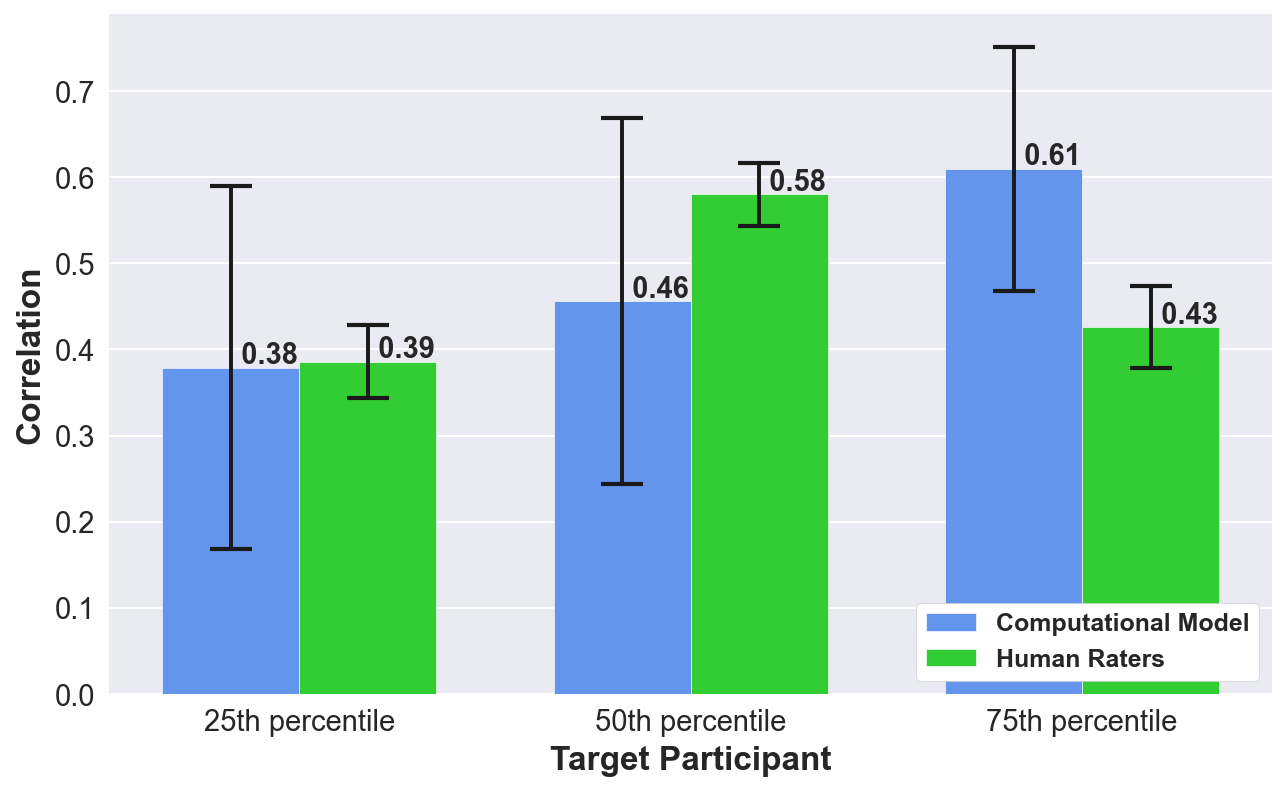

In [49]:
n_steps = 10
cor_h,p_h,cor_comp,p_comp = regCorr(target_list, n_steps, predictions_targets) #correlations
corrs_means = [np.nanmean(x).round(3) for x in cor_h] #humans
pvals_means = [np.nanmean(x).round(3) for x in p_h]
corrs_comps = [np.nanmean(x).round(3) for x in cor_comp] #computational model
pvals_comps = [np.nanmean(x).round(3) for x in p_comp]

# CI
ci_corr_model = [mean_confidence_interval(x) for x in cor_comp] #comp model
yerr_model = [(x[2]-x[1])/2 for x in ci_corr_model]
ci_corr_human = [mean_confidence_interval(x) for x in cor_h] #humans
yerr_human = [(x[2]-x[1])/2 for x in ci_corr_human]

# plot dataframe
# adjust to many percentiles
performance = pd.DataFrame(np.array([["25th percentile", 'Computational Model', corrs_comps[0], yerr_model[0]],
                                      ["50th percentile",'Computational Model', corrs_comps[1], yerr_model[1]],
                                      ["75th percentile", 'Computational Model', corrs_comps[2], yerr_model[2]],
                                          ["25th percentile", 'Human Raters', corrs_means[0], yerr_human[0]],
                                          ["50th percentile",'Human Raters',  corrs_means[1], yerr_human[1]],
                                          ["75th percentile", 'Human Raters',  corrs_means[2], yerr_human[2]]]), columns=["target", "model", "correlation", "yerr"])
performance.iloc[:, -2:] = performance.iloc[:, -2:].astype(float)
labels = performance.target.drop_duplicates().tolist() #bar labels
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(10, 6), dpi = 150) #figure specs
comp = performance[performance.model == 'Computational Model'] #comp model bars
hum = performance[performance.model == 'Human Raters'] #human bars
rects1 = ax.bar(x - width/2, comp.correlation.values, width, label='Computational Model', yerr = comp.yerr.values, capsize=0.2, color = 'cornflowerblue') #bar plots
plt.errorbar(x - width/2, comp.correlation.values,  yerr=comp.yerr.values, fmt=' ', markersize=8, capsize=10, capthick=2, ecolor='k')
rects2 = ax.bar(x + width/2, hum.correlation.values, width, label='Human Raters', yerr = hum.yerr.values, capsize=0.2, color = 'limegreen')
plt.errorbar(x + width/2, hum.correlation.values,  yerr=hum.yerr.values, fmt=' ', markersize=8, capsize=10, capthick=2, ecolor='k')
ax.grid(False, axis='x')

for p in ax.patches:
    ax.annotate("  %.2f" % round(p.get_height(),2), xy=(p.get_x(), p.get_height()),
            xytext=(30, -1), textcoords='offset points', ha="left", va="bottom", fontweight='bold',fontsize=14)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correlation', fontweight = "bold", fontsize = 16)
ax.set_xlabel('Target Participant', fontweight = "bold", fontsize = 16)
# ax.set_title('Comparison of computational model\'s vs human raters\' prediction performance', fontweight = "bold")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 14)
plt.yticks(fontsize = 14)
ax.legend(loc="lower right", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold', 'size':12})

plt.savefig("../plot_data/fig3a.pdf")

Plot 2: Scatter plot (comparison across all test folds)

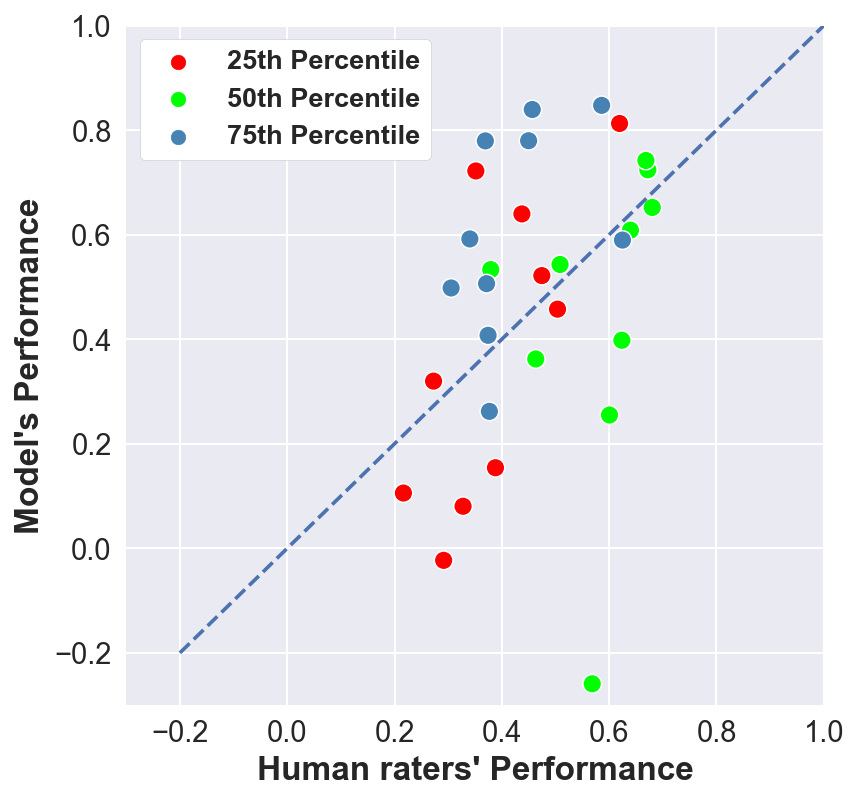

In [50]:
# plot dataframe
# adjust for all percentiles

n_steps = 10
cor_h,p_h,cor_comp,p_comp = regCorr(target_list, n_steps, predictions_targets) #correlations

rows = []
targets=["25th Percentile", "50th Percentile", "75th Percentile"]
for i in range(3):
  humans = nanmean(np.array([cor_h[i][j:j+n_steps] for j in range(0,len(cor_h[i]), 10)]),0) #reshape to folds
# humans = nanmean(np.reshape(cor_h[i], (10,21)), 1)
  model = cor_comp[i]
  target = [targets[i]]*10
  rows.extend(list(zip(humans, model, target)))
df = pd.DataFrame(rows, columns=["humans", "model", "target"])
color_mapping = {'25th Percentile':'red', '50th Percentile':'white', '75th Percentile':'blue'}
                                          
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(6, 6), dpi = 150) #figure specs
# sns.scatterplot(data=df, x="humans", y="model", hue="target", s=80, palette = ['red','lime','blue'], alpha=0.7)
sns.scatterplot(data=df, x="humans", y="model", hue="target", s=80, palette = ['red','lime',"steelblue"], alpha=1.0)
# sns.scatterplot(data=df, x="humans", y="model", hue="target", s=80, palette = ['red','limegreen','deepskyblue'], alpha=0.7)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model\'s Performance', fontweight = "bold", fontsize=16)
ax.set_xlabel('Human raters\' Performance', fontweight = "bold", fontsize=16)
# ax.set_title('Human vs computational performances for each target participant', fontweight = "bold")
ax.legend(loc="upper left", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold','size':13})
ax.plot((-0.2, 1),(-0.2, 1), ls='--')
plt.xlim(-0.3,1)
plt.ylim(-0.3,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#change to save in local directory
plt.savefig("../plot_data/fig3b.svg")

## Analysis II: Breadth (increase targets to maximize coverage of model performances)

Load data (true responses, model predictions)

In [4]:
# Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "big5"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)
h_path = "../human_studies/" + d.upper() + "/" + d.lower()

# best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par)

# load path and necessary variables:
folder, data = chooseData(d)        
embeddings, save = chooseEmb(e)     #LIWC, WORD2VEC, SENTENCEBERT

# get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# get predicted responses of chosen model:
total_preds = pd.read_csv('../results/BIG5/nonReversed/' + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
total_preds.index = total_preds.index.map(str)
total_preds = total_preds.astype(float)

Load and reformat true item responses for analysis

### Compare model to human performance (calculations for main analysis)

In [5]:
# load target responses (original data)
targets_data = pd.read_csv(h_path + "_targets_data.csv", index_col=0)
# load human rater data (revised human study)
human_data = pd.read_csv(h_path + "_qualtrics_cleaned.csv", index_col = 0)
# load model predictions (original prediction model)
model_data = total_preds.loc[targets_data.index]
model_data = pd.merge(model_data, targets_data.target_nr, left_index=True, right_index=True) # add target_nr

# load and reformat information on train/test-folds
df_folds = pd.read_csv(h_path + "_question_folds.csv") # save to files
df_folds.test_items = df_folds.test_items.apply(lambda x: re.sub(r'\[[0-9\.\s]+\]', add_comma, x)).apply(lambda x: re.sub(r'([0-9\.]+)', add_comma, x)).apply(lambda x: np.array(eval(x)[0]))
df_folds.train_items = df_folds.train_items.apply(lambda x: re.sub(r'\[[0-9\.\s]+\]', add_comma, x)).apply(lambda x: re.sub(r'([0-9\.]+)', add_comma, x)).apply(lambda x: np.array(eval(x)[0]))

# calculate fold-level performances for all 60 targets
targets_h, targets_m = targetComparison(targets_data, human_data, model_data, df_folds)
df_comparison = predictionPerformance(targets_data, human_data, model_data, df_folds)

### Average performances and performance distributions

Get average performance and test for significance (against zero)

In [8]:
#humans
h = [x for s in targets_h for x in s]
ttest_h = stats.ttest_1samp(h, 0, nan_policy="omit")
t_h = round(ttest_h[0], 3)
p_h = round(ttest_h[1], 4)

#model
m = [x for s in targets_m for x in s]
ttest_m = stats.ttest_1samp(m, 0, nan_policy="omit")
t_m = round(ttest_m[0], 3)
p_m = round(ttest_m[1], 4)

print("Human raters performance across all targets:")
print("Correlation, t-statistic, p-value, DOF")
print([round(nanmean(h),3), t_h, p_h, len(h)-2])

print("\nModel performance across all targets:")
print("Correlation, t-statistic, p-value, DOF")
print([round(nanmean(m),3), t_m, p_m, len(m)-2])

model = df_comparison[df_comparison.Predictor == "Model"].dropna()
humans = df_comparison[df_comparison.Predictor == "Human"].dropna()

# two-sample independent welch test 
welch_stat = welch_t_test(np.mean(humans.Correlation), np.std(humans.Correlation, ddof=1), humans.Correlation.size,
                           np.mean(model.Correlation), np.std(model.Correlation, ddof=1), model.Correlation.size)

print("\nWelch's t-test: Are model and human performance different?")
print("t-statistic, p-value, DOF")
print(welch_stat) #not significantly different! absolute difference very small

# percentage of positive significant correlations: -> very similar and very positive
pos_cor_h = round(np.mean(df_comparison.Correlation[df_comparison.Predictor == "Human"]>0),3)*100 # 89% positive
pos_cor_m = round(np.mean(df_comparison.Correlation[df_comparison.Predictor == "Model"]>0), 3)*100 # 91% positive 
print("\nModel: " + str(pos_cor_m) + "% significant positive correlations.")
print("Humans: " + str(pos_cor_h) + "% significant positive correlations.")


Human raters performance across all targets:
Correlation, t-statistic, p-value, DOF
[0.49, 36.375, 0.0, 598]

Model performance across all targets:
Correlation, t-statistic, p-value, DOF
[0.47, 38.393, 0.0, 598]

Welch's t-test: Are model and human performance different?
t-statistic, p-value, DOF
(1.075686920255716, 0.28228661679235184, 1183.0566502375164)

Model: 91.3% significant positive correlations.
Humans: 89.5% significant positive correlations.


## Plots

### Bar plots (average performance) and Distributions (across all targets)

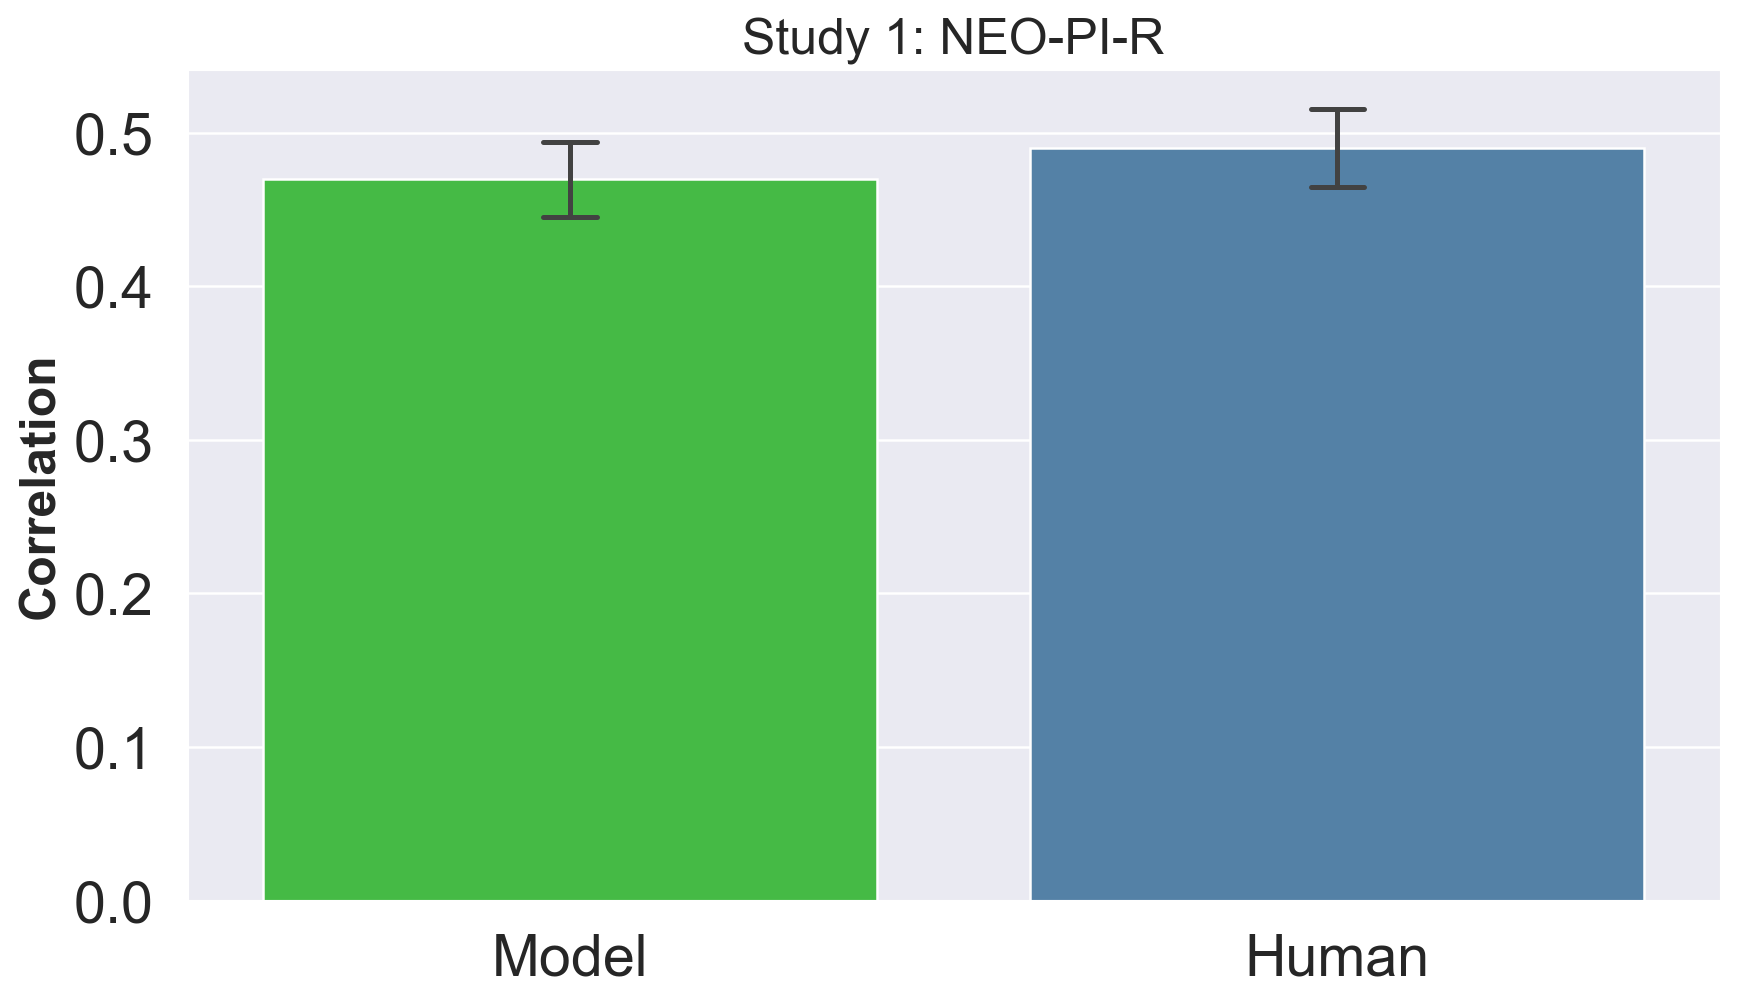

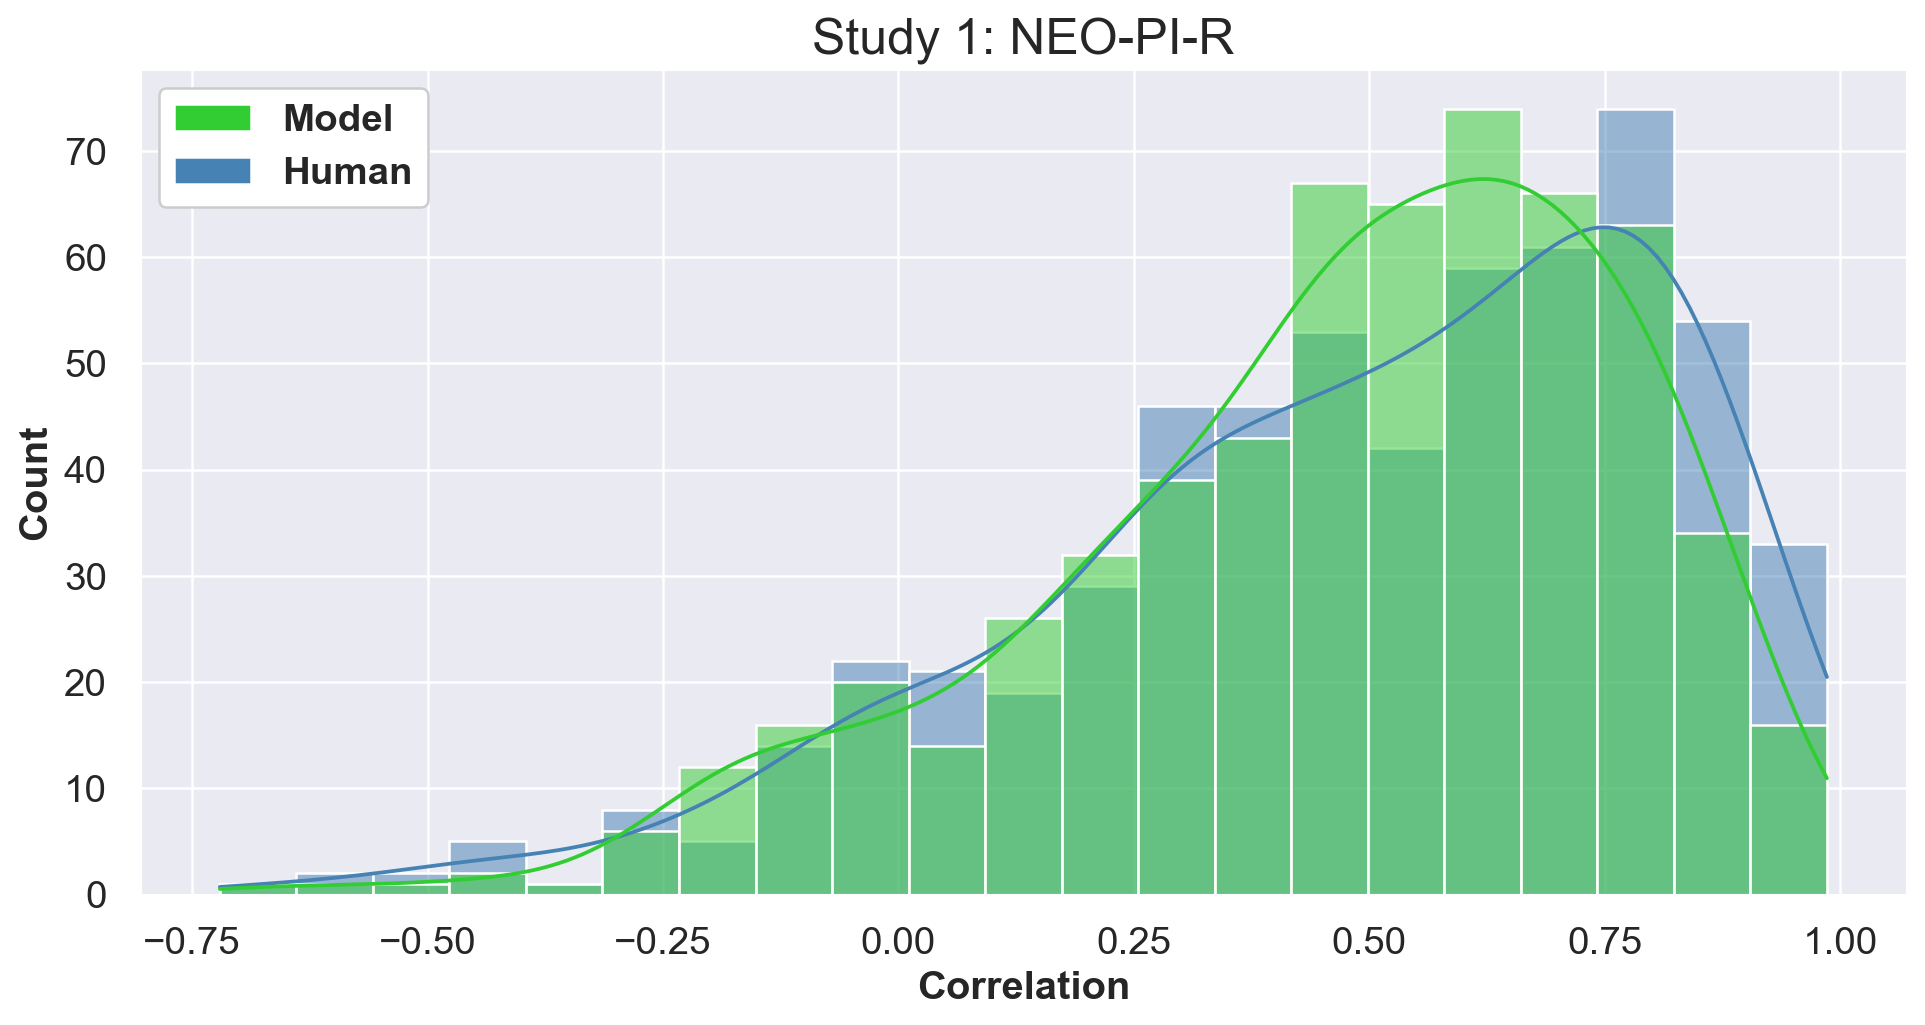

In [6]:
dataset_names = ['Study 1: NEO-PI-R']
i = 0

#set font size, etc
plt.style.use("seaborn-v0_8")
sns.set_context('paper')
sns.set(font_scale = 1.4)

# bar plots
fig  = plt.figure(figsize=(11, 6), dpi= 180)
ax = sns.barplot(y='Correlation', x='Predictor', orient='v', data=df_comparison, errorbar=('ci', 95), 
                 palette=["limegreen","steelblue"], capsize=0.07, errwidth=2)
plt.ylabel("Correlation", fontweight='bold', fontsize=20)
plt.xlabel("", fontweight='bold', fontsize=20, labelpad=-13)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.title(dataset_names[i], fontsize=20)

fig_name = "fig4_" + chr(65+2*i) + ".pdf"
plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')

#Add the distribution plots for each data set:
fig  = plt.figure(figsize=(11, 6), dpi= 180)
palette=["limegreen","steelblue"]
ax = sns.histplot(df_comparison, x="Correlation", kde=True, hue="Predictor", palette = palette)
handles = [Patch(facecolor=item) for item in palette]
labels = df_comparison.Predictor.unique().tolist()
ax.legend(loc = "upper left", handles = handles, labels = labels, frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})
ax.set_ylabel('Count', fontweight = "bold", fontsize = 16)
ax.set_xlabel('Correlation', fontweight = "bold", fontsize = 16)
plt.title(dataset_names[i], fontsize=20)

#save figures
fig_name = "fig5_" + chr(65+2*i) + ".pdf" #update figure name
plt.savefig("../plot_data/" + fig_name, bbox_inches='tight', facecolor='w')

plt.tight_layout()
plt.subplots_adjust(hspace = 1)
plt.show()    

### Create scatterplot (model vs humans)


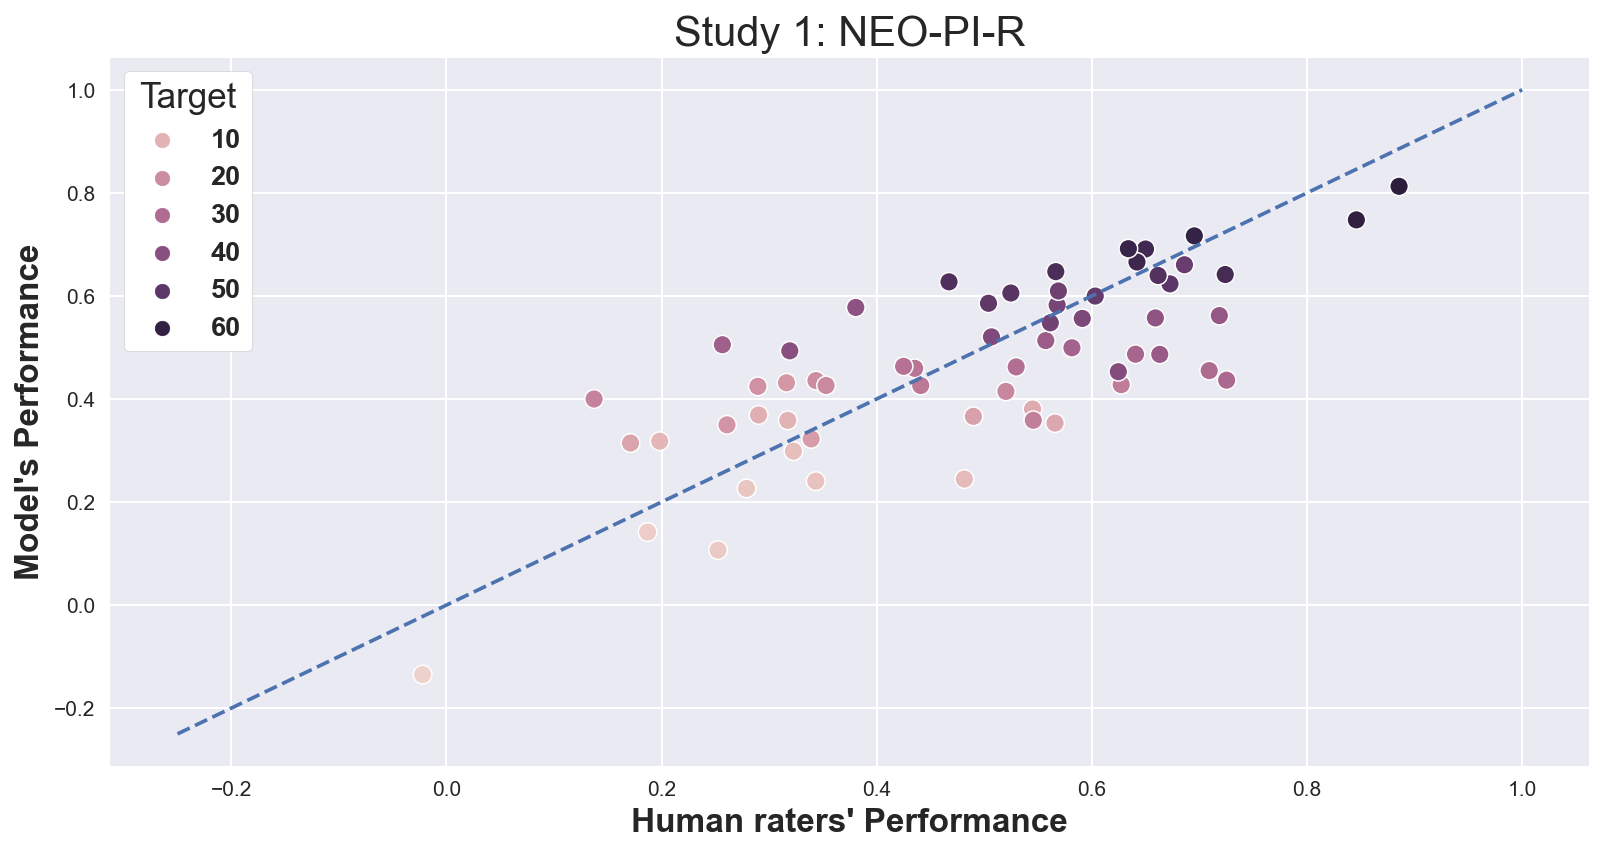

In [7]:
# Looks balanced -> both equally good
j = 0
rows = []
targets=list(range(2,62))
for i in range(60):
  humans = nanmean(targets_h[i])
  model = nanmean(targets_m[i])
  target = targets[i]
  rows.append([humans, model, target])
df = pd.DataFrame(rows, columns=["humans", "model", "target"])

# set figure styles
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(11, 6), dpi = 150) #figure specs
sns.scatterplot(data=df, x="humans", y="model", hue="target", s=80, alpha=1.0)

# Add text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model\'s Performance', fontweight = "bold", fontsize=16)
ax.set_xlabel('Human raters\' Performance', fontweight = "bold", fontsize=16)
ax.legend(loc="upper left", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold','size':13}, title="Target")
ax.plot((-0.25, 1),(-0.25, 1), ls='--')
plt.title("Study 1: NEO-PI-R", fontsize=20)

# download figure
fig_name = "fig5_" + chr(65+j+1) + ".pdf" #start at C (big5 is A)
plt.savefig("../plot_data/" + fig_name, bbox_inches='tight', facecolor='w')

plt.tight_layout()
plt.subplots_adjust(hspace = 1)
plt.show()

Correlation of human and model performance

In [13]:
pearsonr(df.humans, df.model)

PearsonRResult(statistic=0.7600474795947538, pvalue=1.8889040544390168e-12)